<a href="https://colab.research.google.com/github/figonrit/Proyectos/blob/main/Taller_M%C3%B3dulo_4_Fabi%C3%A1n_Gonz%C3%A1lez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Informe Módulo 4
# Fabián González Ritchie
# Diplomado Advanced Analytics
# Universidad de Chile 2021




En el siguiente análisis se estudiarán las variables correspondientes a clientes de un banco, los cuales presentan una serie de características, siendo la relevante para esta investigación si se termina fugando o no.


Para partir se descargan las librerias a utilizar:

In [ ]:
!pip -q install numpy gensim scikit-learn

Luego se importan las librerias a trabajar

In [ ]:
import pandas as pd
import numpy as np
import pandas.util.testing as tm
import matplotlib.pyplot as plt
import seaborn as sn

from pandas.api.types import is_numeric_dtype
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import statsmodels.api as srm

from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
from pydot import graph_from_dot_data

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,roc_curve, auc,r2_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_validate

from joblib import dump, load
import os

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest, chi2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Primero se sube un archivo de google drive:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Una vez cargado nuestro drive se carga el archivo a utilizar:

In [ ]:
ruta_data_set = 'gdrive/My Drive/Colab Notebooks/BASEFUGA2021_F.xls'
data_set = pd.read_excel(ruta_data_set)

Descripcion de variables de la base de datos:

1.   ID: identificador del cliente.
2.   Genero: Género del cliente.
3.   Edad: Edad en años
4.   NIV_Educ: Nivel educacional.
5.   E_Civil: Estado civil.
6.   Ciudad: Ciudad de la oficina
7.   D_Marzo: Deuda de Marzo
8.   D_Abril: Deuda de Abril
9.   D_Mayo: Deuda de Mayo
10.  D_Junio: Deuda de Junio
11.  D_Julio: Deuda de Julio
12.  D_Agosto: Deuda de Agosto
13.  D_Septiembre: Deuda de Septiembre
14.  M_Moroso: Meses en Mora
15.  Monto: Monto preaprobado.
16.  Seguro: Seguro de gravamen.
17.  Fuga: Variable objetivo


# Análisis Exploratorio de Datos

## Estadística descriptiva

Para analizar el comportamiento de los datos de las variables numéricas, se calcula la media, desviación estandar, mínimo, máximo y cuartiles.

Mientras que para las variables categóricas se obtiene la cantidad de categorías de la variable (unique), la moda (top) y la frecuencia de de la moda (freq).

In [ ]:
data_set.describe(include='all')

,ID,GENERO,EDAD,NIV_EDUC,E_CIVIL,CIUDAD,D_Marzo,D_Abril,D_Mayo,D_Junio,D_Julio,D_Agosto,D_Septiembre,M_MOROSO,MONTO,SEGURO,FUGA
count,2294.000000,2283,2292.000000,2281,2282,2290,2.293000e+03,2.293000e+03,2.294000e+03,2.294000e+03,2293.000000,2293.000000,2294.000000,2292.000000,2.293000e+03,2294,2294
unique,NaN,2,NaN,5,4,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,NaN,M,NaN,UNV,CAS,SANTIAGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,NOFUGA
freq,NaN,1385,NaN,946,1429,1389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1816,1157
mean,1147.500000,NaN,43.551920,NaN,NaN,NaN,1.530874e+05,2.726998e+05,1.032315e+05,1.899761e+05,567.093328,3580.321413,1940.639494,1.250436,3.477824e+06,NaN,NaN
std,662.365081,NaN,8.875511,NaN,NaN,NaN,4.982859e+05,4.024124e+05,8.706984e+05,6.705042e+05,1075.500117,8944.021261,9868.816840,0.752197,2.293166e+06,NaN,NaN
min,1.000000,NaN,-50.000000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,5.000000e+05,NaN,NaN
25%,574.250000,NaN,39.000000,NaN,NaN,NaN,0.000000e+00,1.759600e+04,0.000000e+00,0.000000e+00,7.000000,0.000000,0.000000,1.000000,1.700000e+06,NaN,NaN
50%,1147.500000,NaN,44.000000,NaN,NaN,NaN,0.000000e+00,1.341700e+05,0.000000e+00,5.502000e+03,146.000000,0.000000,56.000000,1.000000,2.600000e+06,NaN,NaN
75%,1720.750000,NaN,50.000000,NaN,NaN,NaN,0.000000e+00,3.745150e+05,0.000000e+00,1.749060e+05,630.000000,1493.000000,497.250000,2.000000,4.800000e+06,NaN,NaN


Se observa que existen algunas variables con datos inconsistentes, como "Edad", que posee un valor mínimo de -50 y máximo de 130.

In [ ]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2294 entries, 0 to 2293
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            2294 non-null   int64  
 1   GENERO        2283 non-null   object 
 2   EDAD          2292 non-null   float64
 3   NIV_EDUC      2281 non-null   object 
 4   E_CIVIL       2282 non-null   object 
 5   CIUDAD        2290 non-null   object 
 6   D_Marzo       2293 non-null   float64
 7   D_Abril       2293 non-null   float64
 8   D_Mayo        2294 non-null   int64  
 9   D_Junio       2294 non-null   int64  
 10  D_Julio       2293 non-null   float64
 11  D_Agosto      2293 non-null   float64
 12  D_Septiembre  2294 non-null   int64  
 13  M_MOROSO      2292 non-null   float64
 14  MONTO         2293 non-null   float64
 15  SEGURO        2294 non-null   object 
 16  FUGA          2294 non-null   object 
dtypes: float64(7), int64(4), object(6)
memory usage: 304.8+ KB


De los códigos utilizados anteriormente, se puede inferir que son datos para 2294 clientes, dado que describe() indica que no existen valores únicos en "ID" (en otras palabras, son todos distintos y no se repite ninguno). En el caso de info(), se observa que hay columnas con menor cantidad de datos, por lo que se puede concluir que existen clientes a los que les falta información.


La cantidad de valores perdidos se observa en el siguiente código:

In [ ]:
data_set.isnull().sum()

ID               0
GENERO          11
EDAD             2
NIV_EDUC        13
E_CIVIL         12
CIUDAD           4
D_Marzo          1
D_Abril          1
D_Mayo           0
D_Junio          0
D_Julio          1
D_Agosto         1
D_Septiembre     0
M_MOROSO         2
MONTO            1
SEGURO           0
FUGA             0
dtype: int64

## Gráficos

De manera de visualizar de mejor forma la variable 'EDAD', se realiza el siguiente gráfico:

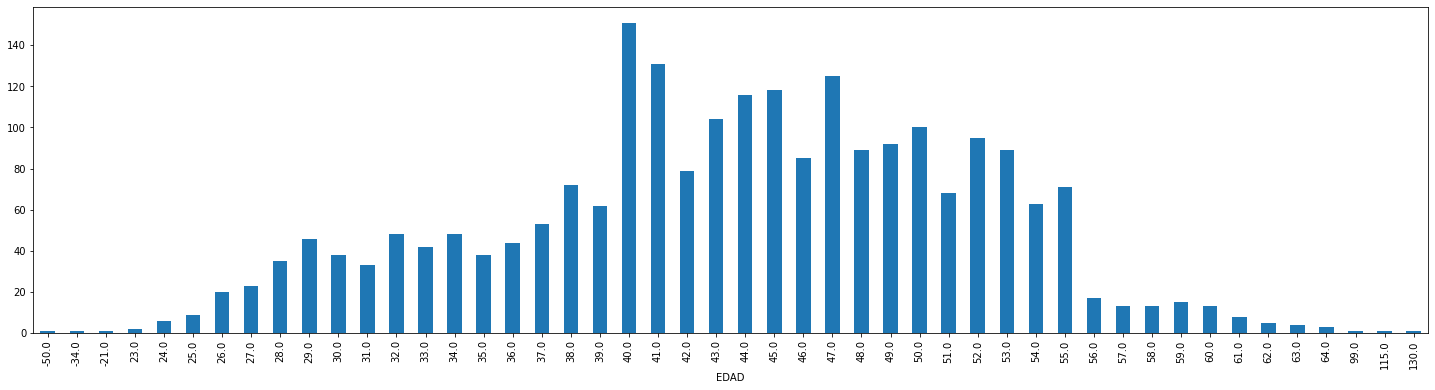

In [ ]:
data_set['EDAD'].value_counts().sort_index().plot.bar(figsize=(25,6))
plt.xlabel('EDAD')
plt.show()

En el gráfico anterior se puede observar que existe una gran cantidad de clientes entre 40 y 47 años, reduciéndose sostenidamente hasta los 55. Luego se produce una reducción drástica en la cantidad de clientes con edad igual o superior a los 56 años.

Además, en este gráfico se logra visualizar de mejor forma los valores inconsistentes, que son aquellos clientes iguales o superiores a 99 años y los que poseen edad negativa.

A continuación, se presenta un histograma de puntos para visualizar valores atípicos (outliers), para las deudas de cada mes:

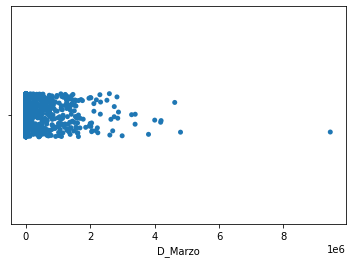

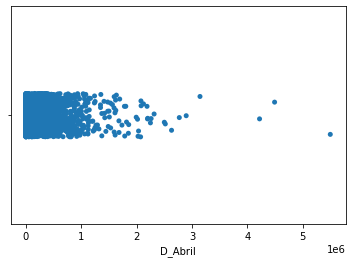

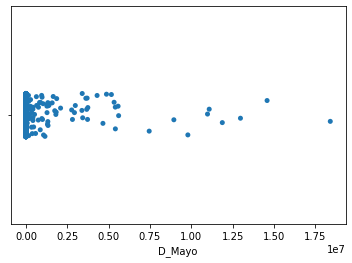

In [ ]:
sn.stripplot(x='D_Marzo', data=data_set)
plt.show()

sn.stripplot(x='D_Abril', data=data_set)
plt.show()

sn.stripplot(x='D_Mayo', data=data_set)
plt.show()



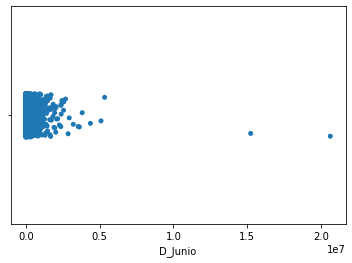

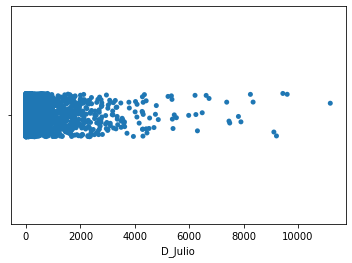

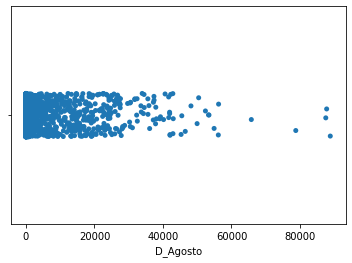

In [ ]:
sn.stripplot(x='D_Junio', data=data_set)
plt.show()

sn.stripplot(x='D_Julio', data=data_set)
plt.show()

sn.stripplot(x='D_Agosto', data=data_set)
plt.show()


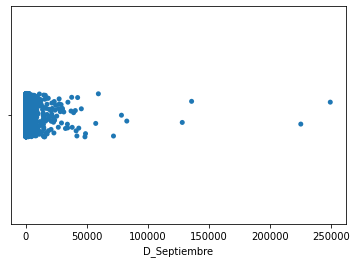

In [ ]:
sn.stripplot(x='D_Septiembre', data=data_set)
plt.show()

Se observa de manera preliminar que hay una alta concentración de datos en torno a cero, en otras palabras, no existe deudas o esta es muy baja para una amplia cantidad de datos.

A continuación se visualiza la relación existente entre la variable 'GENERO' y la variable objetivo ('FUGA')

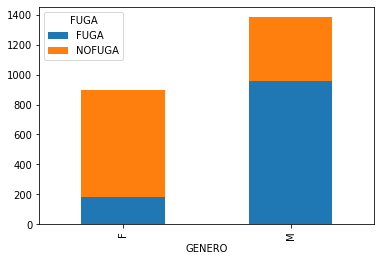

In [ ]:
data_set.groupby(['GENERO', 'FUGA']).size().unstack().plot.bar(stacked=True)
plt.show()

Del gráfico anterior, se puede desprender que existe una notoria superioridad del genero masculino en cantidad de fugas, siendo además superior la proporción de clientes hombres que se fugan con respecto a los que no, caso contrario a lo que ocurre con el genero femenino, que existe una menor cantidad y proporción de clientes que se fugan.

De manera adicional, en el siguiente gráfico se relaciona la variable objetivo con 'NIV_EDUC', presentándose una mayor proporción de clientes fugados para 'UNIV', mientras que 'EUN' presenta en su totalidad clientes no fugados.

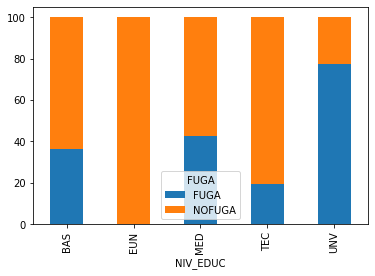

In [ ]:
data_set.groupby(['NIV_EDUC', 'FUGA']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True)
plt.show()

A continuación se observa a escala real la diferencia de datos existentes para cada categoría de 'NIV_EDUC'.

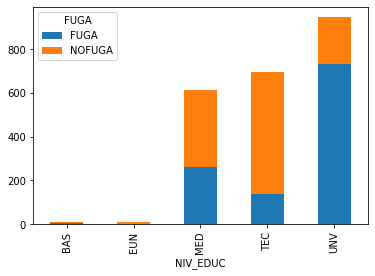

In [ ]:
data_set.groupby(['NIV_EDUC', 'FUGA']).size().unstack().plot.bar(stacked=True)
plt.show()

Como se puede observar, son muy pocos datos para 'BAS' y 'EUN'. En el caso de este último, al detectarse además que se trata solamente de clientes no fugados, se considerará como inconsistencia.

# Limpieza de datos

## Inconsistencias

Quedarán declaradas como nulas las inconsistencias detectadas anteriormente para 'EDAD' y 'NIV_EDUC':

In [ ]:
data_set.loc[data_set['EDAD'] < 0, ['EDAD']] = np.nan
data_set.loc[data_set['EDAD'] > 95, ['EDAD']] = np.nan
data_set.loc[data_set['NIV_EDUC'] == 'EUN', ['NIV_EDUC']] = np.nan

data_set.describe(include='all')

,ID,GENERO,EDAD,NIV_EDUC,E_CIVIL,CIUDAD,D_Marzo,D_Abril,D_Mayo,D_Junio,D_Julio,D_Agosto,D_Septiembre,M_MOROSO,MONTO,SEGURO,FUGA
count,2294.000000,2283,2286.000000,2269,2282,2290,2.293000e+03,2.293000e+03,2.294000e+03,2.294000e+03,2293.000000,2293.000000,2294.000000,2292.000000,2.293000e+03,2294,2294
unique,NaN,2,NaN,4,4,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,NaN,M,NaN,UNV,CAS,SANTIAGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,NOFUGA
freq,NaN,1385,NaN,946,1429,1389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1816,1157
mean,1147.500000,NaN,43.561680,NaN,NaN,NaN,1.530874e+05,2.726998e+05,1.032315e+05,1.899761e+05,567.093328,3580.321413,1940.639494,1.250436,3.477824e+06,NaN,NaN
std,662.365081,NaN,7.990333,NaN,NaN,NaN,4.982859e+05,4.024124e+05,8.706984e+05,6.705042e+05,1075.500117,8944.021261,9868.816840,0.752197,2.293166e+06,NaN,NaN
min,1.000000,NaN,23.000000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,5.000000e+05,NaN,NaN
25%,574.250000,NaN,39.000000,NaN,NaN,NaN,0.000000e+00,1.759600e+04,0.000000e+00,0.000000e+00,7.000000,0.000000,0.000000,1.000000,1.700000e+06,NaN,NaN
50%,1147.500000,NaN,44.000000,NaN,NaN,NaN,0.000000e+00,1.341700e+05,0.000000e+00,5.502000e+03,146.000000,0.000000,56.000000,1.000000,2.600000e+06,NaN,NaN
75%,1720.750000,NaN,50.000000,NaN,NaN,NaN,0.000000e+00,3.745150e+05,0.000000e+00,1.749060e+05,630.000000,1493.000000,497.250000,2.000000,4.800000e+06,NaN,NaN


A continuación se observan la cantidad de datos nulos:

In [ ]:
data_set.isnull().sum()

ID               0
GENERO          11
EDAD             8
NIV_EDUC        25
E_CIVIL         12
CIUDAD           4
D_Marzo          1
D_Abril          1
D_Mayo           0
D_Junio          0
D_Julio          1
D_Agosto         1
D_Septiembre     0
M_MOROSO         2
MONTO            1
SEGURO           0
FUGA             0
dtype: int64

Se reemplaza por media y por moda las columnas con valores NaN:

In [ ]:
data_set['EDAD'].fillna(round(data_set['EDAD'].mean(skipna =True)), inplace=True)
data_set['D_Marzo'].fillna(round(data_set['D_Marzo'].mean(skipna =True)), inplace=True)
data_set['D_Abril'].fillna(round(data_set['D_Abril'].mean(skipna =True)), inplace=True)
data_set['D_Julio'].fillna(round(data_set['D_Julio'].mean(skipna =True)), inplace=True)
data_set['D_Agosto'].fillna(round(data_set['D_Agosto'].mean(skipna =True)), inplace=True)
data_set['M_MOROSO'].fillna(round(data_set['M_MOROSO'].mean(skipna =True)), inplace=True)
data_set['MONTO'].fillna(round(data_set['MONTO'].mean(skipna =True)), inplace=True)
mode = data_set['GENERO'].mode()
data_set['GENERO'].fillna(mode[0], inplace=True)
mode = data_set['NIV_EDUC'].mode()
data_set['NIV_EDUC'].fillna(mode[0], inplace=True)
mode = data_set['E_CIVIL'].mode()
data_set['E_CIVIL'].fillna(mode[0], inplace=True)
mode = data_set['CIUDAD'].mode()
data_set['CIUDAD'].fillna(mode[0], inplace=True)
mode = data_set['NIV_EDUC'].mode()
data_set['NIV_EDUC'].fillna(mode[0], inplace=True)

In [ ]:
data_set.describe(include='all')

,ID,GENERO,EDAD,NIV_EDUC,E_CIVIL,CIUDAD,D_Marzo,D_Abril,D_Mayo,D_Junio,D_Julio,D_Agosto,D_Septiembre,M_MOROSO,MONTO,SEGURO,FUGA
count,2294.000000,2294,2294.000000,2294,2294,2294,2.294000e+03,2.294000e+03,2.294000e+03,2.294000e+03,2294.000000,2294.000000,2294.000000,2294.000000,2.294000e+03,2294,2294
unique,NaN,2,NaN,4,4,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,NaN,M,NaN,UNV,CAS,SANTIAGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,NOFUGA
freq,NaN,1396,NaN,971,1441,1393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1816,1157
mean,1147.500000,NaN,43.563208,NaN,NaN,NaN,1.530874e+05,2.726998e+05,1.032315e+05,1.899761e+05,567.093287,3580.321273,1940.639494,1.250218,3.477824e+06,NaN,NaN
std,662.365081,NaN,7.976424,NaN,NaN,NaN,4.981773e+05,4.023247e+05,8.706984e+05,6.705042e+05,1075.265574,8942.070761,9868.816840,0.751906,2.292665e+06,NaN,NaN
min,1.000000,NaN,23.000000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,5.000000e+05,NaN,NaN
25%,574.250000,NaN,39.000000,NaN,NaN,NaN,0.000000e+00,1.767425e+04,0.000000e+00,0.000000e+00,7.000000,0.000000,0.000000,1.000000,1.700000e+06,NaN,NaN
50%,1147.500000,NaN,44.000000,NaN,NaN,NaN,0.000000e+00,1.344745e+05,0.000000e+00,5.502000e+03,146.000000,0.000000,56.000000,1.000000,2.600000e+06,NaN,NaN
75%,1720.750000,NaN,50.000000,NaN,NaN,NaN,0.000000e+00,3.744250e+05,0.000000e+00,1.749060e+05,629.750000,1493.750000,497.250000,2.000000,4.800000e+06,NaN,NaN


In [ ]:
data_set.isnull().sum()

ID              0
GENERO          0
EDAD            0
NIV_EDUC        0
E_CIVIL         0
CIUDAD          0
D_Marzo         0
D_Abril         0
D_Mayo          0
D_Junio         0
D_Julio         0
D_Agosto        0
D_Septiembre    0
M_MOROSO        0
MONTO           0
SEGURO          0
FUGA            0
dtype: int64

Con lo anterior, se observa que ahora no se tienen valores nulos. Además, se borra 'ID', dado que se perdió el orden del correlativo al eliminar las filas con valores nulos

In [ ]:
del data_set['ID']

# Transformación

## Se transforman los datos a una nueva escala

Primero, asumiendo que no se considerará la variación del valor del dinero en el tiempo, se procede a sumar directamente todos los meses en una variable y ver su comportamiento en un gráfico:

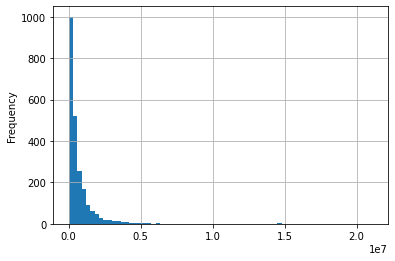

In [ ]:
data_set['Total'] = data_set['D_Marzo'] + data_set['D_Abril'] + data_set['D_Mayo'] + data_set['D_Junio'] + data_set['D_Julio'] + data_set['D_Agosto'] + data_set['D_Septiembre']
data_set['Total'].plot(kind='hist',bins=70, grid=True)
plt.show()

Se observa que la variable esta concentrada en un intervalo, por lo que se aplica su logaritmo:

In [ ]:
data_set['Ln_Total'] = np.log(data_set['Total']+1)

Graficando su logaritmo se puede ver que se asemeja a una distribución normal

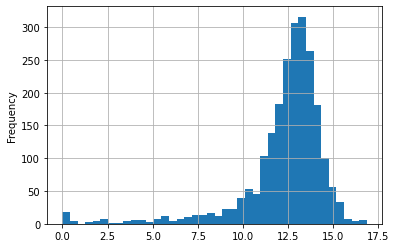

In [ ]:
data_set['Ln_Total'].plot(kind='hist',bins=40, grid=True )
plt.show()

Se elimina la variable "Total" y las variables deudas de todos los meses para quedarnos solo con el logaritmo total.

In [ ]:
del data_set['Total']
del data_set['D_Marzo']
del data_set['D_Abril']
del data_set['D_Mayo']
del data_set['D_Junio']
del data_set['D_Julio']
del data_set['D_Agosto']
del data_set['D_Septiembre']

data_set

,GENERO,EDAD,NIV_EDUC,E_CIVIL,CIUDAD,M_MOROSO,MONTO,SEGURO,FUGA,Ln_Total
0,M,39.0,MED,CAS,LOSANGELES,2.0,2000000.0,NO,NOFUGA,13.089563
1,F,49.0,MED,VIU,SANTIAGO,1.0,7500000.0,SI,NOFUGA,3.891820
2,M,39.0,TEC,CAS,ANTOFAGASTA,1.0,8000000.0,NO,NOFUGA,13.359658
3,F,36.0,UNV,CAS,SANTIAGO,1.0,2600000.0,NO,NOFUGA,12.227457
4,M,44.0,TEC,CAS,SANTIAGO,1.0,6400000.0,NO,NOFUGA,11.365898
...,...,...,...,...,...,...,...,...,...,...
2289,F,43.0,TEC,SOL,SANTIAGO,3.0,1100000.0,SI,NOFUGA,13.386256
2290,M,54.0,TEC,SOL,CONCEPCION,1.0,1800000.0,NO,FUGA,14.054986
2291,M,51.0,UNV,SOL,ARICA,1.0,4200000.0,NO,FUGA,13.502035
2292,M,42.0,UNV,CAS,SANTIAGO,2.0,4600000.0,NO,FUGA,13.408665


## Agregación

Para la variable E_CIVIL se agrupa 'VIU' (viudo) con 'SEP' (separado), dado que se podría asumir que ambas categorías tienen un comportamiento similar.

In [ ]:
data_set['E_CIVIL'] = data_set['E_CIVIL'].replace('VIU', 'SEPA')
data_set['E_CIVIL'] = data_set['E_CIVIL'].replace('SEP', 'SEPA')

Además, se creará una nueva columna llamada "CAPITAL", que será de carácter binario:
*   1: Corresponde a Santiago
*   0: No corresponde a Santiago

La columna 'CIUDAD' será eliminada.

In [ ]:
def capital(string):
  if "SANTIAGO" in string:
    return 1
  else:
    return 0

In [ ]:
data_set["CAPITAL"] = data_set["CIUDAD"].apply(capital)
del data_set["CIUDAD"]
data_set

,GENERO,EDAD,NIV_EDUC,E_CIVIL,M_MOROSO,MONTO,SEGURO,FUGA,Ln_Total,CAPITAL
0,M,39.0,MED,CAS,2.0,2000000.0,NO,NOFUGA,13.089563,0
1,F,49.0,MED,SEPA,1.0,7500000.0,SI,NOFUGA,3.891820,1
2,M,39.0,TEC,CAS,1.0,8000000.0,NO,NOFUGA,13.359658,0
3,F,36.0,UNV,CAS,1.0,2600000.0,NO,NOFUGA,12.227457,1
4,M,44.0,TEC,CAS,1.0,6400000.0,NO,NOFUGA,11.365898,1
...,...,...,...,...,...,...,...,...,...,...
2289,F,43.0,TEC,SOL,3.0,1100000.0,SI,NOFUGA,13.386256,1
2290,M,54.0,TEC,SOL,1.0,1800000.0,NO,FUGA,14.054986,0
2291,M,51.0,UNV,SOL,1.0,4200000.0,NO,FUGA,13.502035,0
2292,M,42.0,UNV,CAS,2.0,4600000.0,NO,FUGA,13.408665,1


## Transformación de variables categóricas a binarias

A continuación, se transformarán todas las variables categóricas de la base de datos en dummies:

In [ ]:
data_set = pd.get_dummies(data_set, columns = ["SEGURO"], drop_first = True)
data_set = pd.get_dummies(data_set, columns = ["NIV_EDUC"], drop_first = True)
data_set = pd.get_dummies(data_set, columns = ["GENERO"], drop_first = True)
data_set = pd.get_dummies(data_set, columns = ["E_CIVIL"], drop_first = True)
data_set = pd.get_dummies(data_set, columns = ["FUGA"], drop_first = True)
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2294 entries, 0 to 2293
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   EDAD          2294 non-null   float64
 1   M_MOROSO      2294 non-null   float64
 2   MONTO         2294 non-null   float64
 3   Ln_Total      2294 non-null   float64
 4   CAPITAL       2294 non-null   int64  
 5   SEGURO_SI     2294 non-null   uint8  
 6   NIV_EDUC_MED  2294 non-null   uint8  
 7   NIV_EDUC_TEC  2294 non-null   uint8  
 8   NIV_EDUC_UNV  2294 non-null   uint8  
 9   GENERO_M      2294 non-null   uint8  
 10  E_CIVIL_SEPA  2294 non-null   uint8  
 11  E_CIVIL_SOL   2294 non-null   uint8  
 12  FUGA_NOFUGA   2294 non-null   uint8  
dtypes: float64(4), int64(1), uint8(8)
memory usage: 107.7 KB


# Selección de atributos

A modo de revisión general, se procede a calcular la desviación estándar de las variables:

In [ ]:
data_set.std()

EDAD            7.976424e+00
M_MOROSO        7.519055e-01
MONTO           2.292665e+06
Ln_Total        2.392271e+00
CAPITAL         4.884715e-01
SEGURO_SI       4.062311e-01
NIV_EDUC_MED    4.430617e-01
NIV_EDUC_TEC    4.600130e-01
NIV_EDUC_UNV    4.941864e-01
GENERO_M        4.881824e-01
E_CIVIL_SEPA    2.896740e-01
E_CIVIL_SOL     4.488143e-01
FUGA_NOFUGA     5.000900e-01
dtype: float64

Como se puede observar, no existe ninguna variable que posea una desviación estándar de cero, por lo que a priori no se puede eliminar ninguna.

**Cálculo la matriz de correlación entre todas las variables de la base de datos:**

                  EDAD  M_MOROSO  ...  E_CIVIL_SOL  FUGA_NOFUGA
EDAD          1.000000  0.093055  ...     0.064811     0.270989
M_MOROSO      0.093055  1.000000  ...     0.133611     0.321848
MONTO         0.155219  0.060626  ...     0.028305     0.114524
Ln_Total      0.054615  0.169449  ...     0.042237     0.133491
CAPITAL       0.022772  0.062274  ...     0.121819     0.184907
SEGURO_SI     0.110470  0.006574  ...     0.216318     0.081396
NIV_EDUC_MED  0.134709  0.020794  ...     0.087388     0.086248
NIV_EDUC_TEC  0.172406  0.146765  ...     0.230752     0.397084
NIV_EDUC_UNV  0.039290  0.158489  ...     0.134337     0.449513
GENERO_M      0.049588  0.227752  ...     0.227062     0.475321
E_CIVIL_SEPA  0.049338  0.036133  ...     0.198710     0.093554
E_CIVIL_SOL   0.064811  0.133611  ...     1.000000     0.228707
FUGA_NOFUGA   0.270989  0.321848  ...     0.228707     1.000000

[13 rows x 13 columns]


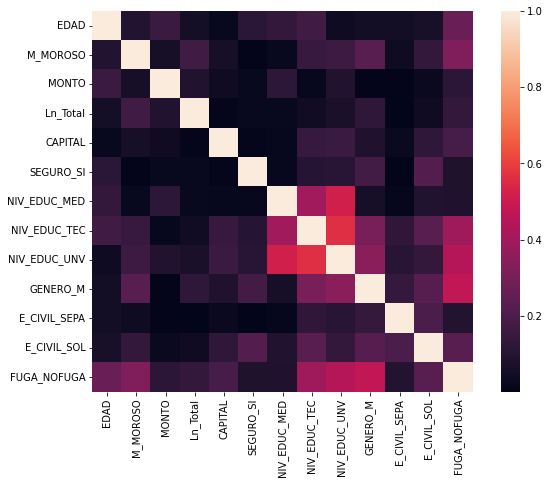

In [ ]:
corrmat = data_set.corr().abs()
f, ax = plt.subplots(figsize=(10, 7))
sn.heatmap(corrmat, square=True);
print(corrmat)

A pesar de que 'NIV_EDUC_UNV' y 'NIV_EDUC_TEC' dan indicios de una eventual redundancia al presentar una correlación cercana a 0.6, no existe una real certeza de que deba eliminarse alguna de las dos, al igual que en otros casos donde se observa una correlación mayor, por lo que se procederá a aplicar test chi-cuadrado, eliminando las que presenten menor relevancia.

**Selección de variables mas relevantes con test chi cuadrado**

Se seleccionarán las 9 variables que tengan el estadístico chi cuadrado mayor, siendo las restantes eliminadas al ser consideradas menos relevantes.

Primero se define como X las variables independientes y como Y la variable dependiente:

In [ ]:
X = data_set.loc[:, data_set.columns != 'FUGA_NOFUGA']
y = data_set.loc[:, data_set.columns == 'FUGA_NOFUGA']
X.shape

(2294, 12)

Ahora se aplica la función SelectKBest con el test chi cuadrado para determinar las variables mas relevantes:

In [ ]:
X_new = SelectKBest(chi2, k=9).fit(X, y)
x_final = X_new.fit_transform(X,y)
x_final.shape
print(x_final)

[[3.9e+01 2.0e+00 2.0e+06 ... 0.0e+00 1.0e+00 0.0e+00]
 [4.9e+01 1.0e+00 7.5e+06 ... 0.0e+00 0.0e+00 0.0e+00]
 [3.9e+01 1.0e+00 8.0e+06 ... 0.0e+00 1.0e+00 0.0e+00]
 ...
 [5.1e+01 1.0e+00 4.2e+06 ... 1.0e+00 1.0e+00 1.0e+00]
 [4.2e+01 2.0e+00 4.6e+06 ... 1.0e+00 1.0e+00 0.0e+00]
 [4.9e+01 1.0e+00 2.1e+06 ... 1.0e+00 1.0e+00 0.0e+00]]


Por último, se obtienen los nombres de las columnas seleccionadas:

In [ ]:
kbest = np.asarray(X.columns)[X_new.get_support()]
print(kbest)

['EDAD' 'M_MOROSO' 'MONTO' 'Ln_Total' 'CAPITAL' 'NIV_EDUC_TEC'
 'NIV_EDUC_UNV' 'GENERO_M' 'E_CIVIL_SOL']


Dadas las variables que se consideraron como las mas relevantes, se procede a eliminar todas las demás:

In [ ]:
del data_set["SEGURO_SI"]
del data_set["NIV_EDUC_MED"]
del data_set['E_CIVIL_SEPA']

#Separación de datos

A continuación, se procede a separar la variable "Fuga" (dependiente) como Y y las demás variables (independientes) como X:

In [ ]:
y = data_set['FUGA_NOFUGA'] #toma el valor de 1 cuando la variable es si y 0 cuando la variable es no
del data_set['FUGA_NOFUGA']
X = data_set

Luego, se separa el total de datos en datos de entrenamiento y de prueba, siendo este último grupo un 30% del total de datos:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
X

,EDAD,M_MOROSO,MONTO,Ln_Total,CAPITAL,NIV_EDUC_TEC,NIV_EDUC_UNV,GENERO_M,E_CIVIL_SOL
0,39.0,2.0,2000000.0,13.089563,0,0,0,1,0
1,49.0,1.0,7500000.0,3.891820,1,0,0,0,0
2,39.0,1.0,8000000.0,13.359658,0,1,0,1,0
3,36.0,1.0,2600000.0,12.227457,1,0,1,0,0
4,44.0,1.0,6400000.0,11.365898,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...
2289,43.0,3.0,1100000.0,13.386256,1,1,0,0,1
2290,54.0,1.0,1800000.0,14.054986,0,1,0,1,1
2291,51.0,1.0,4200000.0,13.502035,0,0,1,1,1
2292,42.0,2.0,4600000.0,13.408665,1,0,1,1,0


#Entrenamiento y Validación

Una vez preparados los datos, se entrenan los modelos con los datos de entrenamiento definidos anteriormente:

## Regresión logistica

Se define el modelo de regresión logística con los X e Y de entrenamiento:

In [ ]:
X_train_reg = X_train[['EDAD','M_MOROSO','MONTO','Ln_Total','CAPITAL','NIV_EDUC_TEC','NIV_EDUC_UNV','GENERO_M','E_CIVIL_SOL']]
X_test_reg = X_test[['EDAD','M_MOROSO','MONTO','Ln_Total','CAPITAL','NIV_EDUC_TEC','NIV_EDUC_UNV','GENERO_M','E_CIVIL_SOL']]

Luego, se ejecuta la regresión logística:

In [ ]:
result = srm.Logit(y_train, X_train_reg).fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: inf
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            FUGA_NOFUGA   No. Observations:                 1605
Model:                          Logit   Df Residuals:                     1596
Method:                           MLE   Df Model:                            8
Date:                Sun, 02 Jan 2022   Pseudo R-squ.:                     inf
Time:                        22:48:24   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
EDAD            -0.0162      0.006     -2.645      0.008      -0.028      -0.004
M_MOROSO        -0.6121     

/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Se observa que ninguna de las variables posee un valor P mayor a 5%, por lo que se conservan todas las variables al tener betas significativos.

Aplicando prueba de la blancura, se tiene lo siguiente:

1. A mayor edad, menor riesgo de fuga (ok)
2. Mientras más meses en mora, menor riesgo de fuga (eliminar)
3. A mayor monto preaprobado, mayor riesgo de fuga (eliminar)
4. A mayor deuda total, mayor riesgo de fuga (ok)
5. Si es de Santiago, menor riesgo de fuga (ok)
6. Si el nivel educacional es técnico, mayor riesgo de fuga (ok)
7. Si el nivel educacional es universitario, menor riesgo de fuga (ok)
8. Si el género es masculino, menor riesgo de fuga (ok)
9. Si el estado civil es soltero, mayor riesgo de fuga (eliminar)

Dado que existen algunas variables que pueden ser inconsistentes con la realidad del negocio, se procederá a eliminar las variables indicadas y luego a ejecutar la regresión logística con las variables consideradas.

In [ ]:
X_train_reg = X_train[['EDAD','Ln_Total','CAPITAL','NIV_EDUC_TEC','NIV_EDUC_UNV','GENERO_M']]
X_test_reg = X_test[['EDAD','Ln_Total','CAPITAL','NIV_EDUC_TEC','NIV_EDUC_UNV','GENERO_M']]

clf = LogisticRegression(random_state=0).fit(X_train_reg, y_train)
pd.DataFrame(zip(X_train_reg.columns, np.transpose(clf.coef_.tolist()[0])), columns=['features', 'coef'])

,features,coef
0,EDAD,-0.081567
1,Ln_Total,-0.090987
2,CAPITAL,-0.635246
3,NIV_EDUC_TEC,0.820258
4,NIV_EDUC_UNV,-1.245810
5,GENERO_M,-1.910515


Dado lo obtenido en este modelo, se observa que las variables de genero y nivel educacional son las que mayormente impactan en que el cliente no se fugue. En otras palabras, si es hombre y/o universitario, tendrá menor riesgo de fuga.

Por otra parte, la variable de nivel educacional técnico es la única de las variables consideradas que aumenta la probabilidad de fuga del cliente.

## Arbol de decisión

Se define el método de clasificación, cuyo criterio será de entropía:

In [ ]:
arbol = DecisionTreeClassifier(criterion = 'entropy')

Se establecen los siguientes parámetros:


*   max_leaf_nodes: Número máximo de división del nodo.
*   max_depth: Profundidad máxima del árbol.



In [ ]:
parametros= {'max_leaf_nodes': [5,18,30], 'max_depth':[2,3,4]}

Con la funcion "GridSearchCV" de la libreria Sklearn, se encuentra la mejor combinación de parámetros realizando validación cruzada de 10. Luego se entrenan los modelos con los X e Y de entrenamiento:

In [ ]:
tree_cv=GridSearchCV(arbol,parametros,cv=10)
tree_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': [2, 3, 4], 'max_leaf_nodes': [5, 18, 30]})

A continuación, se presentan los mejores parámetros segun la grilla:

In [ ]:
print('Best params:')
print(tree_cv.best_params_)

Best params:
{'max_depth': 4, 'max_leaf_nodes': 18}


Como se puede observar, la mejor combinación corresponde a una profundidad de 4 y una cantidad de nodos máxima de 18.

Se guarda el mejor modelo de la grilla para luego obtener sus resultados de predicción:

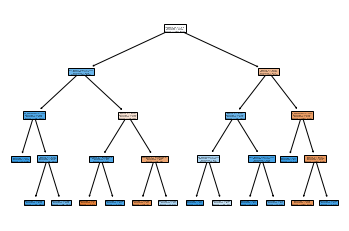

In [ ]:
arbol = tree_cv.best_estimator_
tree.plot_tree(arbol, feature_names = data_set.columns, filled = True)
plt.show()


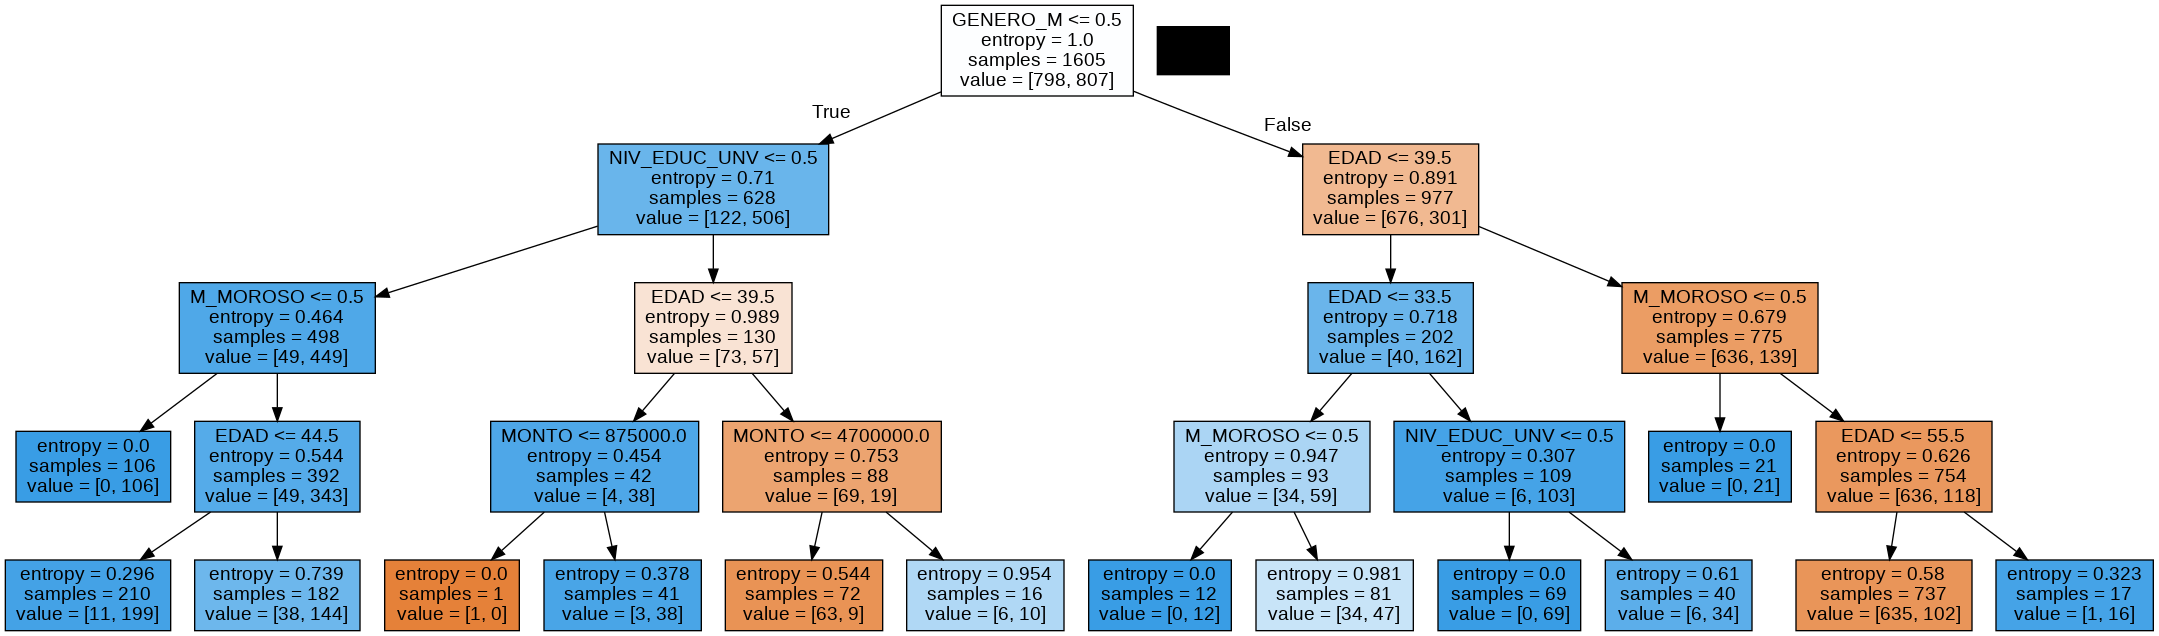

In [ ]:
dot_data = StringIO()
export_graphviz(arbol, out_file=dot_data, feature_names=data_set.columns,filled= True )
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

De acuerdo al árbol obtenido se tienen tres nodos que logran reducir al máximo la entropía:

1. Para género femenino, nivel educacional universitario, edad menor o igual a 39 y monto preaprobado menor o igual a 875.000, se encontró un cliente no fugado y ninguno fugado.

2. Para género masculino, edad menor o igual a 33, sin meses morosos, se encuentran 12 clientes fugados y ninguno no fugado.

3. Para genero masculino, edad menor o igual a 33 años, nivel educacional distinto a universitario, se tienen 69 clientes fugados y ninguno no fugado.

**Los modelos a continuación es necesario realizarlos con la base de datos normalizada:**

In [ ]:
scaler = MinMaxScaler()
scaler_data = scaler.fit(data_set)
data_set_scaled = pd.DataFrame(scaler_data.transform(data_set), index=data_set.index, columns=data_set.columns)

In [ ]:
data_set_scaled

,EDAD,M_MOROSO,MONTO,Ln_Total,CAPITAL,NIV_EDUC_TEC,NIV_EDUC_UNV,GENERO_M,E_CIVIL_SOL
0,0.390244,0.666667,0.200000,0.776091,0.0,0.0,0.0,1.0,0.0
1,0.634146,0.333333,0.933333,0.230749,1.0,0.0,0.0,0.0,0.0
2,0.390244,0.333333,1.000000,0.792105,0.0,1.0,0.0,1.0,0.0
3,0.317073,0.333333,0.280000,0.724976,1.0,0.0,1.0,0.0,0.0
4,0.512195,0.333333,0.786667,0.673893,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
2289,0.487805,1.000000,0.080000,0.793682,1.0,1.0,0.0,0.0,1.0
2290,0.756098,0.333333,0.173333,0.833331,0.0,1.0,0.0,1.0,1.0
2291,0.682927,0.333333,0.493333,0.800546,0.0,0.0,1.0,1.0,1.0
2292,0.463415,0.666667,0.546667,0.795010,1.0,0.0,1.0,1.0,0.0


Se divide nuevamente los datos:

In [ ]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(data_set_scaled, y, test_size=0.3, random_state = 0)

##K-vecinos más cercanos

Se define el método de clasificación a utilizar:


In [ ]:
Knn = KNeighborsClassifier()

Se definen los parámetros para hacer una grilla con validación cruzada y encontrar los parámetros del modelo de k-vecinos más cercanos que más se ajuste a los datos y entregue mejores resultados. Los parámetros a analizar son los siguientes:

*   n_neighbors: Número de vecinos.
*   metric: Metrica de distancia que se utiliza para el árbol.

In [ ]:
parametros= {'n_neighbors': [3,5,11,19], 'metric':['euclidean','manhattan']}

Lo descrito anteriormente se realiza mediante la función "GridSearchCV" de la libreria Sklearn. Luego, se entrenan los modelos con los X e Y de entrenamiento:

In [ ]:
knn_cv=GridSearchCV(Knn,parametros,cv=10)
knn_cv.fit(X_train_scaled, y_train_scaled)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 11, 19]})

A continuación se determinan los mejores parámetros según la grilla:

In [ ]:
print('Best params for k-neighbors:')
print(knn_cv.best_params_)

Best params for k-neighbors:
{'metric': 'manhattan', 'n_neighbors': 5}


Se obtiene como mejor combinación la utilización de la métrica manhattan (distancias absolutas) y un numero de vecinos (k) de 5.

Se guarda el mejor modelo de la grilla para luego obtener sus resultados de predicción:

In [ ]:
Knn = knn_cv.best_estimator_

A continuación se grafican los puntajes obtenidos en la grilla con los distintos parámetros probados:

In [ ]:
grid_results = pd.DataFrame(knn_cv.cv_results_)

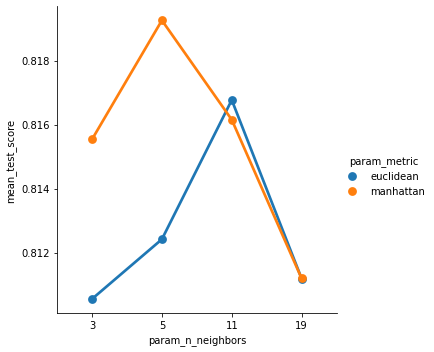

In [ ]:
sn.catplot(x="param_n_neighbors", y="mean_test_score", kind="point",  hue="param_metric",data=grid_results);


Como se puede observar, la métrica manhattan supera el mejor puntaje de la métrica euclidiana con un k de 5. Para esta última métrica, el mejor puntaje se obtiene para un k igual a 11, el cual está en torno a un 0.817.

##Random forest

Los parámetros a analizar para este modelo son los siguientes:


*   n_estimators: Cantidad de árboles a realizar. Para este caso se fija en 100.
*   max_features: Cantidad de variables que se deben considerar al buscar la mejor división.
*   max_depth: Profundidad máxima del arbol.
*   criterion: Función para medir la calidad de la división. Los dos criterios admitidos son la impureza de Gini (gini) y la entropía (entropy).

Luego se realiza la grilla con cross validation para obtener los mejores parámetros y por último se grafican los puntajes obtenidos en ella.

Best params for Random Forest:
{'criterion': 'gini', 'max_depth': 6, 'max_features': 3}


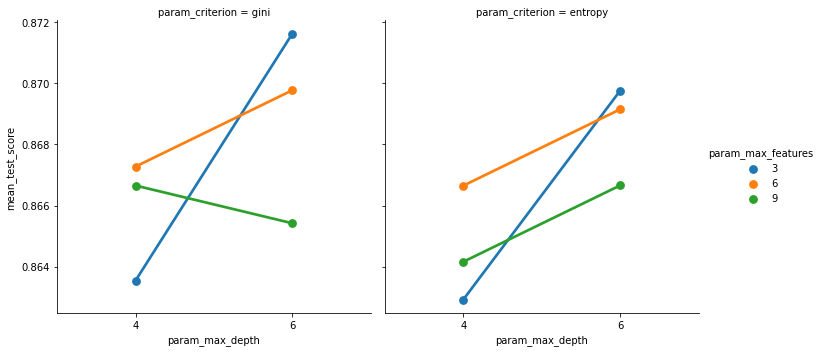

In [ ]:
rf = RandomForestClassifier(n_estimators=100)

#Realización de la grilla
parametros={  'max_features': [3, 6, 9], 'max_depth' : [4,6],'criterion' :['gini', 'entropy']}
rf_cv=GridSearchCV(rf,parametros,cv=10)
rf_cv.fit(X_train_scaled, y_train_scaled)

#Determinación de los mejores parametros según la grilla
print('Best params for Random Forest:')
print(rf_cv.best_params_)

#Se guarda el mejor modelo para luego obtener sus resultados de validación
rf = rf_cv.best_estimator_

#Transformación de los resultados de la grilla en un dataframe
grid_results = pd.DataFrame(rf_cv.cv_results_)

#Grafica los puntaje obtenidos segun cada parametro analizado
sn.catplot(x="param_max_depth", y="mean_test_score", hue="param_max_features", kind="point", col="param_criterion",data=grid_results);


Para este modelo, los mejores resultados se obtienen utilizando el criterio gini, profundidad de los árboles máxima de 6 y cantidad de variables de 3.

# Evaluación


A continuación se evaluará el rendimiento de los modelos previamente entrenados para determinar su capacidad de predicción de la variable objetivo, para esto se utilizarán los datos de testeo.

Se crea un data frame vacío para guardar los resultados de predicción de cada modelo y luego graficarlos. Columnas:

1. classifiers
2. False Positive Rate
3. True Positive Rate
4. AUC

In [ ]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

## Regresión logistica

Se calcula el accuracy del modelo con los datos de testeo:

In [ ]:
Ac_reg = clf.score(X_test_reg, y_test)
print('Accuracy of Logistic Regression: {:.2f}'.format(Ac_reg))

Accuracy of Logistic Regression: 0.79


Se obtiene la predicción de los valores de la variable y a partir de los datos de prueba de la variable x

In [ ]:
Y_pred_regresion = clf.predict(X_test_reg)

Se calcula la matriz de confusión del modelo

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


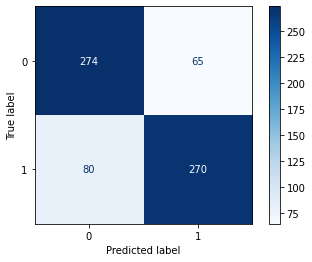

In [ ]:
metrics.plot_confusion_matrix(clf, X_test_reg, y_test, values_format='.6g', cmap='Blues')
plt.show()

El modelo de regresión logística analizado anteriormente tiene una precisión de un 79%, lo cual es bastante bueno tomando en cuenta las variables consideradas.

De esta matriz se desprende que la mayor cantidad de aciertos del modelo se obtiene con los clientes no fugados, con un total de 274 aciertos, versus 65 errores. En el caso de los clientes que se fugan, acierta tiene un total de acierto de 270 vs 80 errores, por lo que el modelo precide levemente mejor a los clientes no fugados.

A continuación se obtiene el reporte de clasificación entre la variable objetivo de prueba y la variable objetivo de predicción

In [ ]:
Reporte = classification_report(y_test, Y_pred_regresion)
print('Reporte de clasificacion: ')
print(Reporte)

Reporte de clasificacion: 
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       339
           1       0.81      0.77      0.79       350

    accuracy                           0.79       689
   macro avg       0.79      0.79      0.79       689
weighted avg       0.79      0.79      0.79       689



En esta tabla se puede observar de mejor manera lo descrito anteriormente,ya que se obtiene un 81% de acertividad de clientes no fugados vs un 77% de fugados.

A continuación se calcula el area bajo la curva ROC:

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test_reg)[:,1])
auc = roc_auc_score(y_test, Y_pred_regresion)
print('AUC: %.3f' % auc)

AUC: 0.790


Se agregan los resultados obtenidos para luego graficar la curvas ROC del modelo

In [ ]:
result_table = result_table.append({'classifiers': 'Regresion logistica','fpr':fpr,'tpr':tpr, 'auc':auc}, ignore_index=True)

**Se realiza el mismo procedimiento con todos los modelos como se muestra a continuación:**

## Arbol de decisión

Accuracy of Decision trees: 0.87


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


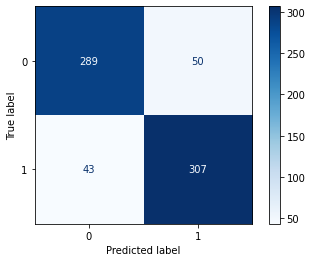

Reporte de clasificacion: 
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       339
           1       0.86      0.88      0.87       350

    accuracy                           0.87       689
   macro avg       0.87      0.86      0.86       689
weighted avg       0.87      0.87      0.86       689

AUC: 0.865


In [ ]:
# Accuracy
Ac_tree = arbol.score(X_test, y_test)
print('Accuracy of Decision trees: {:.2f}'.format(Ac_tree))

#Se obtiene el valor de la variable objetivo a partir de los datos de la variable independiente de prueba
Y_pred_tree = arbol.predict(X_test)

#matriz de confusion
metrics.plot_confusion_matrix(arbol, X_test, y_test, values_format='.6g', cmap='Blues')
plt.show()

#Reporte de clasificacion
Reporte = classification_report(y_test, Y_pred_tree)
print('Reporte de clasificacion: ')
print(Reporte)

# Calculo de AUC
fpr, tpr, thresholds = roc_curve(y_test, arbol.predict_proba(X_test)[:,1])
auc = roc_auc_score(y_test, Y_pred_tree)
print('AUC: %.3f' % auc)


result_table = result_table.append({'classifiers': 'Arbol de decisión','fpr':fpr,'tpr':tpr, 'auc':auc}, ignore_index=True)


La matriz de confusión obtenida en árbol de decisión tiene un comportamiento distinto a la de la regresión logística, en el sentido de que logra predecir de mejor manera los clientes fugados por sobre los no fugados.

En cuanto al AUC, se obtiene un valor de 0.865, superior al 0.790 obtenido en regresión logística, por lo que resulta ser un mejor modelo.

## K-vecinos mas cercanos

Accuracy of k-vecinos mas cercanos: 0.81


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


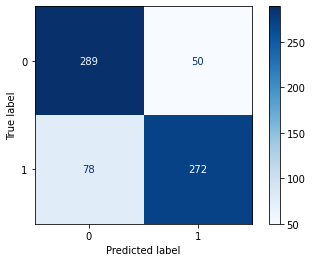

Reporte de clasificacion: 
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       339
           1       0.84      0.78      0.81       350

    accuracy                           0.81       689
   macro avg       0.82      0.81      0.81       689
weighted avg       0.82      0.81      0.81       689

AUC: 0.815


In [ ]:
# Accuracy
Ac_knn = Knn.score(X_test_scaled, y_test_scaled) #con el modelo entrenado en entrenamiento
print('Accuracy of k-vecinos mas cercanos: {:.2f}'.format(Ac_knn))

#Se obtiene el valor de la variable objetivo a partir de los datos de la variable independiente de prueba
Y_pred_knn = Knn.predict(X_test_scaled)

#matriz de confusion
metrics.plot_confusion_matrix(Knn, X_test_scaled, y_test_scaled, values_format='.6g', cmap='Blues')
plt.show()

#Reporte de clasificacion
Reporte = classification_report(y_test_scaled, Y_pred_knn)
print('Reporte de clasificacion: ')
print(Reporte)

# Calculo de AUC
fpr, tpr, thresholds = roc_curve(y_test_scaled, Knn.predict_proba(X_test_scaled)[:,1])
auc = roc_auc_score(y_test_scaled, Y_pred_knn)
print('AUC: %.3f' % auc)

#Para agregar a la tabla de resultados
result_table = result_table.append({'classifiers': 'K-vecinos mas cercanos','fpr':fpr,'tpr':tpr, 'auc':auc}, ignore_index=True)


En cuanto a la matriz de confusión de K-vecinos, sigue el mismo comportamiento de la regresión logística en cuanto a las proporciones de aciertos.

Con respecto al AUC, presenta un 0.815, el cual es inferior al obtenido en arbol de decisión y superior al de regresión logística.

## Random Forest

Accuracy of random forest: 0.88


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


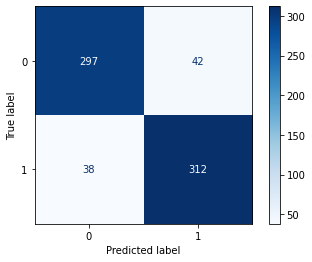

Reporte de clasificacion: 
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       339
           1       0.88      0.89      0.89       350

    accuracy                           0.88       689
   macro avg       0.88      0.88      0.88       689
weighted avg       0.88      0.88      0.88       689

AUC: 0.884


In [ ]:
# Accuracy
Ac_rf = rf.score(X_test_scaled, y_test_scaled) #con el modelo entrenado en entrenamiento
print('Accuracy of random forest: {:.2f}'.format(Ac_rf))

#Se obtiene el valor de la variable objetivo a partir de los datos de la variable independiente de prueba
Y_pred_rf = rf.predict(X_test_scaled)

#matriz de confusion
metrics.plot_confusion_matrix(rf, X_test_scaled, y_test_scaled, values_format='.6g', cmap='Blues')
plt.show()

#Reporte de clasificacion
Reporte = classification_report(y_test_scaled, Y_pred_rf)
print('Reporte de clasificacion: ')
print(Reporte)

# Calculo de AUC
fpr, tpr, thresholds = roc_curve(y_test_scaled, rf.predict_proba(X_test_scaled)[:,1])
auc = roc_auc_score(y_test_scaled, Y_pred_rf)
print('AUC: %.3f' % auc)

#Para agregar a la tabla de resultados
result_table = result_table.append({'classifiers': 'Random forest','fpr':fpr,'tpr':tpr, 'auc':auc}, ignore_index=True)


La matriz de confusión de Ramdom Forest indica que se predice levemente mejor los clientes fugados que los no fugados, y se equivoca más en los clientes no fugados, con un total de 42.

En cuanto a la AUC, este modelo presenta el mejor desempeño de los cuatro expuestos, con un valor de 0.884.

## Curvas ROC


Se grafican las curvas ROC de todos los modelos:

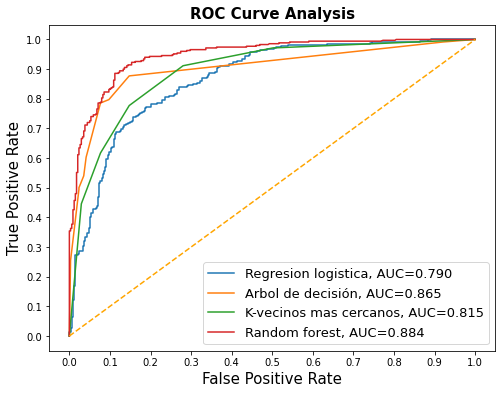

In [ ]:
result_table.set_index('classifiers', inplace=True)

#plot
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'],
             result_table.loc[i]['tpr'],
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

En este gráfico se puede observar lo que se ha expuesto anteriormente, en relación a que el modelo con mejor desempeño es Random Forest, sin considerar ningún umbral.

Además es importante destacar que la aplicación de cualquiera de estos cuatro modelos predice mejor que el azar (lanzamiento de una moneda).


# Guardado modelo

A continuación se guarda este modelo entrenado en un archivo para luego realizar predicciones con el.

In [ ]:
%cd /content
dump(rf, 'gdrive/My Drive/Colab Notebooks/modelo_entrenado.joblib')

/content


['gdrive/My Drive/Colab Notebooks/modelo_entrenado.joblib']

Procedemos a cargar la segunda hoja de la base de datos y el modelo entrenado y guardado anteriormente:

In [ ]:
ruta_data_set = 'gdrive/My Drive/Colab Notebooks/BASEFUGA2021_F.xls'
data_set = pd.read_excel(ruta_data_set, sheet_name = 'VALIDACION')

In [ ]:
modelo_entrenado = load('gdrive/My Drive/Colab Notebooks/modelo_entrenado.joblib')

#Limpieza de datos

A continuación, se realizará el mismo pre procesamiento de la base de predicción de la primera planilla, omitiendo el análisis con gráficos:

In [ ]:
data_set.describe(include='all')

,ID,GENERO,EDAD,NIV_EDUC,E_CIVIL,CIUDAD,D_Marzo,D_Abril,D_Mayo,D_Junio,D_Julio,D_Agosto,D_Septiembre,M_MOROSO,MONTO,SEGURO,FUGA
count,1200.000000,1196,1200.000000,1186,1197,1192,1.200000e+03,1.200000e+03,1.200000e+03,1.200000e+03,1200.000000,1200.00000,1200.000000,1198.000000,1.200000e+03,1192,0.0
unique,NaN,2,NaN,5,4,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,NaN,M,NaN,UNV,CAS,SANTIAGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,NaN
freq,NaN,691,NaN,472,697,717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,928,NaN
mean,2894.500000,NaN,43.382500,NaN,NaN,NaN,1.388176e+05,2.604670e+05,9.807232e+04,1.845051e+05,499.236667,3184.33250,2178.825000,1.232888,3.341250e+06,NaN,NaN
std,346.554469,NaN,8.754621,NaN,NaN,NaN,4.416169e+05,3.810925e+05,6.588924e+05,3.801482e+05,921.331742,8092.93584,10019.762703,0.775580,2.254036e+06,NaN,NaN
min,2295.000000,NaN,21.000000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.00000,0.000000,0.000000,5.000000e+05,NaN,NaN
25%,2594.750000,NaN,38.000000,NaN,NaN,NaN,0.000000e+00,1.415900e+04,0.000000e+00,0.000000e+00,3.000000,0.00000,0.000000,1.000000,1.600000e+06,NaN,NaN
50%,2894.500000,NaN,44.000000,NaN,NaN,NaN,0.000000e+00,1.225470e+05,0.000000e+00,1.716900e+04,124.000000,0.00000,90.500000,1.000000,2.500000e+06,NaN,NaN
75%,3194.250000,NaN,50.000000,NaN,NaN,NaN,0.000000e+00,3.282468e+05,0.000000e+00,1.932172e+05,607.250000,1500.25000,572.250000,2.000000,4.500000e+06,NaN,NaN


In [ ]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            1200 non-null   int64  
 1   GENERO        1196 non-null   object 
 2   EDAD          1200 non-null   int64  
 3   NIV_EDUC      1186 non-null   object 
 4   E_CIVIL       1197 non-null   object 
 5   CIUDAD        1192 non-null   object 
 6   D_Marzo       1200 non-null   int64  
 7   D_Abril       1200 non-null   int64  
 8   D_Mayo        1200 non-null   int64  
 9   D_Junio       1200 non-null   int64  
 10  D_Julio       1200 non-null   int64  
 11  D_Agosto      1200 non-null   int64  
 12  D_Septiembre  1200 non-null   int64  
 13  M_MOROSO      1198 non-null   float64
 14  MONTO         1200 non-null   int64  
 15  SEGURO        1192 non-null   object 
 16  FUGA          0 non-null      float64
dtypes: float64(2), int64(10), object(5)
memory usage: 159.5+ KB


In [ ]:
data_set.loc[data_set['EDAD'] < 0, ['EDAD']] = np.nan
data_set.loc[data_set['EDAD'] > 95, ['EDAD']] = np.nan
data_set.loc[data_set['NIV_EDUC'] == 'EUN', ['NIV_EDUC']] = np.nan

data_set.isnull().sum()

ID                 0
GENERO             4
EDAD               1
NIV_EDUC          17
E_CIVIL            3
CIUDAD             8
D_Marzo            0
D_Abril            0
D_Mayo             0
D_Junio            0
D_Julio            0
D_Agosto           0
D_Septiembre       0
M_MOROSO           2
MONTO              0
SEGURO             8
FUGA            1200
dtype: int64

In [ ]:
data_set['M_MOROSO'].fillna(round(data_set['M_MOROSO'].mean(skipna =True)), inplace=True)
data_set['EDAD'].fillna(round(data_set['EDAD'].mean(skipna =True)), inplace=True)
mode = data_set['GENERO'].mode()
data_set['GENERO'].fillna(mode[0], inplace=True)
mode = data_set['NIV_EDUC'].mode()
data_set['NIV_EDUC'].fillna(mode[0], inplace=True)
mode = data_set['E_CIVIL'].mode()
data_set['E_CIVIL'].fillna(mode[0], inplace=True)
mode = data_set['CIUDAD'].mode()
data_set['CIUDAD'].fillna(mode[0], inplace=True)
mode = data_set['SEGURO'].mode()
data_set['SEGURO'].fillna(mode[0], inplace=True)


In [ ]:
data_set.describe(include='all')

,ID,GENERO,EDAD,NIV_EDUC,E_CIVIL,CIUDAD,D_Marzo,D_Abril,D_Mayo,D_Junio,D_Julio,D_Agosto,D_Septiembre,M_MOROSO,MONTO,SEGURO,FUGA
count,1200.000000,1200,1200.000000,1200,1200,1200,1.200000e+03,1.200000e+03,1.200000e+03,1.200000e+03,1200.000000,1200.00000,1200.000000,1200.000000,1.200000e+03,1200,0.0
unique,NaN,2,NaN,4,4,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,NaN,M,NaN,UNV,CAS,SANTIAGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NO,NaN
freq,NaN,695,NaN,489,700,725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,936,NaN
mean,2894.500000,NaN,43.318333,NaN,NaN,NaN,1.388176e+05,2.604670e+05,9.807232e+04,1.845051e+05,499.236667,3184.33250,2178.825000,1.232500,3.341250e+06,NaN,NaN
std,346.554469,NaN,8.470151,NaN,NaN,NaN,4.416169e+05,3.810925e+05,6.588924e+05,3.801482e+05,921.331742,8092.93584,10019.762703,0.774991,2.254036e+06,NaN,NaN
min,2295.000000,NaN,21.000000,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.00000,0.000000,0.000000,5.000000e+05,NaN,NaN
25%,2594.750000,NaN,38.000000,NaN,NaN,NaN,0.000000e+00,1.415900e+04,0.000000e+00,0.000000e+00,3.000000,0.00000,0.000000,1.000000,1.600000e+06,NaN,NaN
50%,2894.500000,NaN,44.000000,NaN,NaN,NaN,0.000000e+00,1.225470e+05,0.000000e+00,1.716900e+04,124.000000,0.00000,90.500000,1.000000,2.500000e+06,NaN,NaN
75%,3194.250000,NaN,50.000000,NaN,NaN,NaN,0.000000e+00,3.282468e+05,0.000000e+00,1.932172e+05,607.250000,1500.25000,572.250000,2.000000,4.500000e+06,NaN,NaN


In [ ]:
data_set.isnull().sum()

ID                 0
GENERO             0
EDAD               0
NIV_EDUC           0
E_CIVIL            0
CIUDAD             0
D_Marzo            0
D_Abril            0
D_Mayo             0
D_Junio            0
D_Julio            0
D_Agosto           0
D_Septiembre       0
M_MOROSO           0
MONTO              0
SEGURO             0
FUGA            1200
dtype: int64

In [ ]:
del data_set['ID']

In [ ]:
data_set['Total'] = data_set['D_Marzo'] + data_set['D_Abril'] + data_set['D_Mayo'] + data_set['D_Junio'] + data_set['D_Julio'] + data_set['D_Agosto'] + data_set['D_Septiembre']

In [ ]:
data_set['Ln_Total'] = np.log(data_set['Total']+1)

In [ ]:
del data_set['Total']
del data_set['D_Marzo']
del data_set['D_Abril']
del data_set['D_Mayo']
del data_set['D_Junio']
del data_set['D_Julio']
del data_set['D_Agosto']
del data_set['D_Septiembre']

In [ ]:
data_set['E_CIVIL'] = data_set['E_CIVIL'].replace('VIU', 'SEPA')
data_set['E_CIVIL'] = data_set['E_CIVIL'].replace('SEP', 'SEPA')

In [ ]:
def capital(string):
  if "SANTIAGO" in string:
    return 1
  else:
    return 0

In [ ]:
data_set["CAPITAL"] = data_set["CIUDAD"].apply(capital)
del data_set["CIUDAD"]
data_set

,GENERO,EDAD,NIV_EDUC,E_CIVIL,M_MOROSO,MONTO,SEGURO,FUGA,Ln_Total,CAPITAL
0,M,45.0,UNV,CAS,1.0,2700000,NO,NaN,12.261522,1
1,F,30.0,TEC,SOL,0.0,1900000,NO,NaN,10.765470,0
2,M,51.0,UNV,CAS,1.0,1100000,SI,NaN,13.770904,0
3,F,41.0,MED,SOL,3.0,3500000,NO,NaN,12.891462,1
4,M,42.0,MED,CAS,1.0,2000000,NO,NaN,12.772386,1
...,...,...,...,...,...,...,...,...,...,...
1195,F,49.0,UNV,CAS,2.0,2400000,NO,NaN,13.570984,1
1196,F,48.0,UNV,CAS,1.0,2000000,SI,NaN,7.427739,0
1197,F,41.0,TEC,SOL,1.0,1800000,SI,NaN,12.810137,1
1198,F,38.0,TEC,CAS,1.0,3700000,NO,NaN,10.213799,1


In [ ]:
data_set = pd.get_dummies(data_set, columns = ["SEGURO"], drop_first = True)
data_set = pd.get_dummies(data_set, columns = ["NIV_EDUC"], drop_first = True)
data_set = pd.get_dummies(data_set, columns = ["GENERO"], drop_first = True)
data_set = pd.get_dummies(data_set, columns = ["E_CIVIL"], drop_first = True)

del data_set["SEGURO_SI"]
del data_set["NIV_EDUC_MED"]
del data_set['E_CIVIL_SEPA']

data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   EDAD          1200 non-null   float64
 1   M_MOROSO      1200 non-null   float64
 2   MONTO         1200 non-null   int64  
 3   FUGA          0 non-null      float64
 4   Ln_Total      1200 non-null   float64
 5   CAPITAL       1200 non-null   int64  
 6   NIV_EDUC_TEC  1200 non-null   uint8  
 7   NIV_EDUC_UNV  1200 non-null   uint8  
 8   GENERO_M      1200 non-null   uint8  
 9   E_CIVIL_SOL   1200 non-null   uint8  
dtypes: float64(4), int64(2), uint8(4)
memory usage: 61.1 KB


In [ ]:
data_set

,EDAD,M_MOROSO,MONTO,FUGA,Ln_Total,CAPITAL,NIV_EDUC_TEC,NIV_EDUC_UNV,GENERO_M,E_CIVIL_SOL
0,45.0,1.0,2700000,NaN,12.261522,1,0,1,1,0
1,30.0,0.0,1900000,NaN,10.765470,0,1,0,0,1
2,51.0,1.0,1100000,NaN,13.770904,0,0,1,1,0
3,41.0,3.0,3500000,NaN,12.891462,1,0,0,0,1
4,42.0,1.0,2000000,NaN,12.772386,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1195,49.0,2.0,2400000,NaN,13.570984,1,0,1,0,0
1196,48.0,1.0,2000000,NaN,7.427739,0,0,1,0,0
1197,41.0,1.0,1800000,NaN,12.810137,1,1,0,0,1
1198,38.0,1.0,3700000,NaN,10.213799,1,1,0,0,0


Una vez hecho el preprocesamiento, serán guardadas las variables utilizadas en un nuevo dataframe:

In [ ]:
X = pd.DataFrame(data_set[['EDAD', 'M_MOROSO', 'MONTO', 'Ln_Total','CAPITAL','NIV_EDUC_TEC','NIV_EDUC_UNV','GENERO_M','E_CIVIL_SOL']])

In [ ]:
X

,EDAD,M_MOROSO,MONTO,Ln_Total,CAPITAL,NIV_EDUC_TEC,NIV_EDUC_UNV,GENERO_M,E_CIVIL_SOL
0,45.0,1.0,2700000,12.261522,1,0,1,1,0
1,30.0,0.0,1900000,10.765470,0,1,0,0,1
2,51.0,1.0,1100000,13.770904,0,0,1,1,0
3,41.0,3.0,3500000,12.891462,1,0,0,0,1
4,42.0,1.0,2000000,12.772386,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
1195,49.0,2.0,2400000,13.570984,1,0,1,0,0
1196,48.0,1.0,2000000,7.427739,0,0,1,0,0
1197,41.0,1.0,1800000,12.810137,1,1,0,0,1
1198,38.0,1.0,3700000,10.213799,1,1,0,0,0


Es importante considerar que se debe normalizar la base de datos, tal como se hizo en el preprocesamiento de la base de entrenamiento:

In [ ]:
scaler = MinMaxScaler()
scaler_data = scaler.fit(X)
data_set_scaled = pd.DataFrame(scaler_data.transform(X), index=X.index, columns=X.columns)

In [ ]:
X

,EDAD,M_MOROSO,MONTO,Ln_Total,CAPITAL,NIV_EDUC_TEC,NIV_EDUC_UNV,GENERO_M,E_CIVIL_SOL
0,45.0,1.0,2700000,12.261522,1,0,1,1,0
1,30.0,0.0,1900000,10.765470,0,1,0,0,1
2,51.0,1.0,1100000,13.770904,0,0,1,1,0
3,41.0,3.0,3500000,12.891462,1,0,0,0,1
4,42.0,1.0,2000000,12.772386,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
1195,49.0,2.0,2400000,13.570984,1,0,1,0,0
1196,48.0,1.0,2000000,7.427739,0,0,1,0,0
1197,41.0,1.0,1800000,12.810137,1,1,0,0,1
1198,38.0,1.0,3700000,10.213799,1,1,0,0,0


#Predicción

Con el modelo de entrenamiento y las variables independientes ya definidas y trabajadas, se realiza la predicción de la variable objetivo como se muestra a continuación:

In [ ]:
prediccion = modelo_entrenado.predict(data_set_scaled)

A continuación, se muestran los resultados de la predicción, siendo 0 los clientes que no se fugan y 1 los que sí:

In [ ]:
print(prediccion)

[0 1 0 ... 1 1 0]


In [ ]:
prediccion.sum()/prediccion.size

0.5266666666666666

Como se puede observar, el modelo indica que un 52,66% del total de clientes corresponderán a clientes fugados.

Dado que se obtiene un mayor beneficio por detectar clientes fugados, se bajará el umbral a 0.1 para detectar mayores clientes fugados.

In [ ]:
prediccion_2 = (modelo_entrenado.predict_proba(data_set_scaled)[:,1] >= 0.10).astype(int)

In [ ]:
print(prediccion_2)

[0 1 1 ... 1 1 0]


In [ ]:
prediccion_2.sum()/prediccion_2.size

0.8416666666666667

Con la disminución del umbral, se logró subir la proporción de fugados a 80,25%.

#Exportar datos a excel

In [ ]:
X

,EDAD,M_MOROSO,MONTO,Ln_Total,CAPITAL,NIV_EDUC_TEC,NIV_EDUC_UNV,GENERO_M,E_CIVIL_SOL
0,45.0,1.0,2700000,12.261522,1,0,1,1,0
1,30.0,0.0,1900000,10.765470,0,1,0,0,1
2,51.0,1.0,1100000,13.770904,0,0,1,1,0
3,41.0,3.0,3500000,12.891462,1,0,0,0,1
4,42.0,1.0,2000000,12.772386,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...
1195,49.0,2.0,2400000,13.570984,1,0,1,0,0
1196,48.0,1.0,2000000,7.427739,0,0,1,0,0
1197,41.0,1.0,1800000,12.810137,1,1,0,0,1
1198,38.0,1.0,3700000,10.213799,1,1,0,0,0


A continuación se agrega a la columna FUGA la predicción obtenida:

In [ ]:
X['FUGA'] = prediccion_2
X

,EDAD,M_MOROSO,MONTO,Ln_Total,CAPITAL,NIV_EDUC_TEC,NIV_EDUC_UNV,GENERO_M,E_CIVIL_SOL,FUGA
0,45.0,1.0,2700000,12.261522,1,0,1,1,0,0
1,30.0,0.0,1900000,10.765470,0,1,0,0,1,1
2,51.0,1.0,1100000,13.770904,0,0,1,1,0,1
3,41.0,3.0,3500000,12.891462,1,0,0,0,1,1
4,42.0,1.0,2000000,12.772386,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
1195,49.0,2.0,2400000,13.570984,1,0,1,0,0,1
1196,48.0,1.0,2000000,7.427739,0,0,1,0,0,1
1197,41.0,1.0,1800000,12.810137,1,1,0,0,1,1
1198,38.0,1.0,3700000,10.213799,1,1,0,0,0,1


Finalmente, se exporta la base de datos a excel y se la guarda en drive:

In [ ]:
X.to_excel('BaseFuga_prediccion.xlsx')
!cp BaseFuga_prediccion.xlsx "gdrive/My Drive/Colab Notebooks/"

# Discusiones

De acuerdo al resultado de los modelos expuestos anteriormente, proponen las siguientes políticas comerciales con el objetivo de reducir la fuga de clientes:

1. Generar un enfoque de captación de clientes universitarios, con el objetivo de que éstos posean un alto nivel de concentración en la cartera de clientes.
2. Ofrecer planes diferenciados para clientes de nivel educacional técnico.
3. Reducir el monto preaprobado para personas menores de 40 años de edad.
4. Generar facilidades de pagos para clientes con alta morosidad.
5. Generar productos para clientes de la capital, los cuales tienen menor probabilidad de fuga.

# Conclusiones

Dado los resultados obtenidos al ejecutar los cuatro modelos, la obtención de Random Forest como mejor modelo va de la mano con la simplicidad en la elaboración de los árboles, ya que buscó explicar el modelo con pocas variables a diferencia de los modelos de Regresión Logística y Árbol de decisión.

En el caso de Regresión logística, la prueba de la blancura resulta vital en el desempeño que tendrá el modelo, por lo que es importante el conocimiento que se tenga en el negocio, para la ejecución de un modelo confiable.

Con respecto a Árbol de decisión, el modelo tendió a sobreajustarse, ya que elaboró árboles complejos con varias restricciones, lo cual llevó a la obtención de nodos con baja y nula entropía.